In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import properscoring as ps
import pyreadr
from isodisreg import idr
import pandas as pd
from scipy.integrate import quad
import scipy as sc

import os
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from utils.dataloader import get_train_val_loader, get_test_loader
from networks.cnn import CNN_ES

In [2]:
def retransform(params):
    result = np.zeros(shape = params.shape)
    result[:,0] = np.exp(params[:,0])
    result[:,1] = params[:,1]*2
    return result  

In [3]:
def corr_func(h, method, r, s):
    if method=="brown":
        res = np.power((h/r),s)
    elif method=="powexp":
        res = np.exp(-np.power((h/r),s))        
    elif method == "whitmat":
        res = np.power(2, (1-s))/sc.special.gamma(s)*\
              np.power((h/r),2)*sc.special.kv(s, (h/r))
    return res    

In [4]:
def extremal_coefficient(h, method, r, s):
    if method=="brown":
        res = 2*sc.stats.norm.cdf(np.sqrt(corr_func(h, method, r, s))/2,loc = 0, scale = 1)    
    else:
        res = 1+np.sqrt(1-corr_func(h, method, r, s)/2)        
    return res    

In [5]:
def error_function(h, model, method, true, est):
    r_true, s_true = true
    r_est, s_est = est
    if method == "corr":
        error = np.power(corr_func(h, model, r_true, s_true)- corr_func(h, model, r_est, s_est),2)
    elif method =="ext":
        error = np.power(extremal_coefficient(h, model, r_true, s_true)- extremal_coefficient(h, model, r_est, s_est),2)
    return error

In [6]:
def get_imse(data, model, method):
    pred = data[0:2]
    params = data[2:4]
    error, _ = quad(error_function, 0, 40, args = (model, method, pred, params))
    return error

In [7]:
def get_metrics(pred, param, model):
    rmse = np.sqrt(np.mean((np.power(pred-param,2)), axis = 0))
    mae = np.mean(np.abs(pred-param), axis = 0)
    bias = np.mean(pred-param, axis = 0)
    imse_ext = np.mean(np.array([get_imse(x, model, "ext") for x in np.append(pred, param, axis = 1)]))
    
    
    print(f"RMSE: {np.round(rmse,2)}")
    #print(f"MAE: {np.round(mae,2)}")
    print(f"Ext - IMSE: {np.round(imse_ext,4)}")
    
    #print(f"Bias: {np.round(bias,2)}")

In [8]:
def interval_score(
    observations,
    alpha,
    q_left=None,
    q_right=None,
):

    sharpness = q_right - q_left
    calibration = (
        (
            np.clip(q_left - observations, a_min=0, a_max=None)
            + np.clip(observations - q_right, a_min=0, a_max=None)
        )
        * 2
        / alpha
    )
    total = sharpness + calibration
    return total, sharpness, calibration

In [9]:
exp = "exp_5"
test_samples = 500

In [10]:
# Dataloader
path = f"../data/{exp}/data/"
model = "brown"
dataloader, _ = get_test_loader(data_path = path, model = model, batch_size = 1000)

In [11]:
#Load model
net = CNN_ES(sample_dim = 100)
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/{model}_cnn_es.pt"))

<All keys matched successfully>

In [12]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()

In [13]:
param_tf = retransform(param)
pred_tf = retransform(pred)
mean_pred = np.mean(pred_tf, axis = 2)

In [14]:
r_lower = np.quantile(pred_tf[:,0], 0.025, axis = 1)
r_upper = np.quantile(pred_tf[:,0], 0.975, axis = 1)
s_lower = np.quantile(pred_tf[:,1], 0.025, axis = 1)
s_upper = np.quantile(pred_tf[:,1], 0.975, axis = 1)

In [15]:
r_coverage = np.sum((param_tf[:,0] >= r_lower) & ((param_tf[:,0] <= r_upper)))/test_samples*100
s_coverage = np.sum((param_tf[:,1] >= s_lower) & ((param_tf[:,1] <= s_upper)))/test_samples*100

In [16]:
alpha = 0.05
r_is, _, _ = interval_score(param_tf[:,0], alpha, r_lower, r_upper)
r_is = np.mean(r_is)
s_is, _, _ = interval_score(param_tf[:,1], alpha, s_lower, s_upper)
s_is = np.mean(s_is)

In [17]:
print(f"Model: {model}\nCoverage {r_coverage:.2f}%, {s_coverage:.2f}% \nIS: {r_is:.4f}, {s_is:.4f}")

Model: brown
Coverage 81.00%, 92.40% 
IS: 2.5432, 1.1702


In [18]:
# Brown metrics
get_metrics(mean_pred, param_tf, model)

RMSE: [0.49 0.27]
Ext - IMSE: 0.2745


# Plot generated samples

In [19]:
samples = np.random.randint(0,test_samples,25)

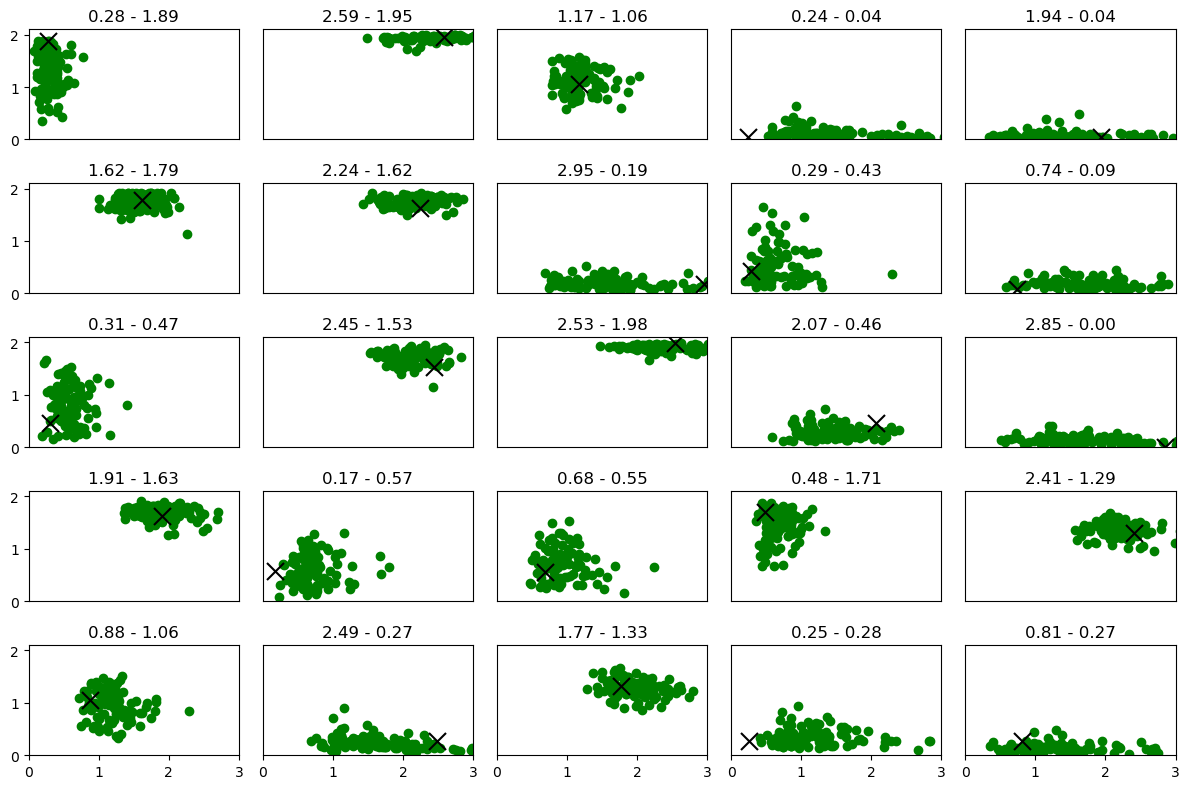

In [20]:
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i, sample in enumerate(samples):
    axs[i].scatter(x = pred_tf[sample,0], y = pred_tf[sample,1], color = "green")
    axs[i].scatter(x = param_tf[sample,0], y = param_tf[sample,1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[sample,0]:.2f} - {param_tf[sample,1]:.2f}")   
    axs[i].set_ylim([0,2.1])
    axs[i].set_xlim([0,3])
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()